Imports


In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import os
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# MCS PyData tools
import McsPy
import McsPy.McsData
from McsPy import ureg, Q_

# VISUALIZATION TOOLS
import matplotlib.pyplot as plt
%matplotlib inline

# SUPRESS WARNINGS
import warnings
warnings.filterwarnings('ignore')

# autoreload modules
%load_ext autoreload
%autoreload 2

# import bombcell module
import bombcell as bc

✅ ipywidgets available - interactive GUI ready


In [2]:
import sys
from pathlib import Path
from pprint import pprint 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bombcell as bc

Functions

In [3]:
def plot_analog_stream_channel(analog_stream, channel_idx, from_in_s=0, to_in_s=None, show=True):
    """
    Plots data from a single AnalogStream channel
    
    :param analog_stream: A AnalogStream object
    :param channel_idx: A scalar channel index (0 <= channel_idx < # channels in the AnalogStream)
    :param from_in_s: The start timestamp of the plot (0 <= from_in_s < to_in_s). Default: 0
    :param to_in_s: The end timestamp of the plot (from_in_s < to_in_s <= duration). Default: None (= recording duration)
    :param show: If True (default), the plot is directly created. For further plotting, use show=False
    """
    # extract basic information
    ids = [c.channel_id for c in analog_stream.channel_infos.values()]
    channel_id = ids[channel_idx]
    channel_info = analog_stream.channel_infos[channel_id]
    sampling_frequency = channel_info.sampling_frequency.magnitude
   
    # get start and end index
    from_idx = max(0, int(from_in_s * sampling_frequency))
    if to_in_s is None:
        to_idx = analog_stream.channel_data.shape[1]
    else:
        to_idx = min(analog_stream.channel_data.shape[1], int(to_in_s * sampling_frequency))
        
    # get the timestamps for each sample
    time = analog_stream.get_channel_sample_timestamps(channel_id, from_idx, to_idx)

    # scale time to seconds:
    scale_factor_for_second = Q_(1,time[1]).to(ureg.s).magnitude
    time_in_sec = time[0] * scale_factor_for_second
    
    # get the signal
    signal = analog_stream.get_channel_in_range(channel_id, from_idx, to_idx)

    # scale signal to µV:
    scale_factor_for_uV = Q_(1,signal[1]).to(ureg.uV).magnitude
    signal_in_uV = signal[0] * scale_factor_for_uV

    # construct the plot
    _ = plt.figure(figsize=(20,6))
    _ = plt.plot(time_in_sec, signal_in_uV)
    _ = plt.xlabel('Time (%s)' % ureg.s)
    _ = plt.ylabel('Voltage (%s)' % ureg.uV)
    _ = plt.title('Channel %s' % channel_info.info['Label'])
    if show:
        plt.show()

In [4]:
def extract_waveforms(signal, fs, spikes_idx, pre, post):
    """
    Extract spike waveforms as signal cutouts around each spike index as a spikes x samples numpy array
    
    :param signal: The signal as a 1-dimensional numpy array
    :param fs: The sampling frequency in Hz
    :param spikes_idx: The sample index of all spikes as a 1-dim numpy array
    :param pre: The duration of the cutout before the spike in seconds
    :param post: The duration of the cutout after the spike in seconds
    """
    cutouts = []
    pre_idx = int(pre * fs)
    post_idx = int(post * fs)
    for index in spikes_idx:
        if index-pre_idx >= 0 and index+post_idx <= signal.shape[0]:
            cutout = signal[(index-pre_idx):(index+post_idx)]
            cutouts.append(cutout)
    return np.stack(cutouts)

In [5]:
def detect_threshold_crossings(signal, fs, threshold, dead_time):
    """
    Detect threshold crossings in a signal with dead time and return them as an array
    
    The signal transitions from a sample above the threshold to a sample below the threshold for a detection and
    the last detection has to be more than dead_time apart from the current one.
    
    :param signal: The signal as a 1-dimensional numpy array
    :param fs: The sampling frequency in Hz
    :param threshold: The threshold for the signal
    :param dead_time: The dead time in seconds. 
    """
    dead_time_idx = dead_time * fs
    threshold_crossings = np.diff((signal <= threshold).astype(int) > 0).nonzero()[0]
    distance_sufficient = np.insert(np.diff(threshold_crossings) >= dead_time_idx, 0, True)
    while not np.all(distance_sufficient):
        # repeatedly remove all threshold crossings that violate the dead_time
        threshold_crossings = threshold_crossings[distance_sufficient]
        distance_sufficient = np.insert(np.diff(threshold_crossings) >= dead_time_idx, 0, True)
    return threshold_crossings

def get_next_minimum(signal, index, max_samples_to_search):
    """
    Returns the index of the next minimum in the signal after an index
    
    :param signal: The signal as a 1-dimensional numpy array
    :param index: The scalar index 
    :param max_samples_to_search: The number of samples to search for a minimum after the index
    """
    search_end_idx = min(index + max_samples_to_search, signal.shape[0])
    min_idx = np.argmin(signal[index:search_end_idx])
    return index + min_idx

def align_to_minimum(signal, fs, threshold_crossings, search_range):
    """
    Returns the index of the next negative spike peak for all threshold crossings
    
    :param signal: The signal as a 1-dimensional numpy array
    :param fs: The sampling frequency in Hz
    :param threshold_crossings: The array of indices where the signal crossed the detection threshold
    :param search_range: The maximum duration in seconds to search for the minimum after each crossing
    """
    search_end = int(search_range*fs)
    aligned_spikes = [get_next_minimum(signal, t, search_end) for t in threshold_crossings]
    return np.array(aligned_spikes)

In [6]:
def plot_waveforms(cutouts, fs, pre, post, n=100, color='k', show=True):
    """
    Plot an overlay of spike cutouts
    
    :param cutouts: A spikes x samples array of cutouts
    :param fs: The sampling frequency in Hz
    :param pre: The duration of the cutout before the spike in seconds
    :param post: The duration of the cutout after the spike in seconds
    :param n: The number of cutouts to plot, or None to plot all. Default: 100
    :param color: The line color as a pyplot line/marker style. Default: 'k'=black
    :param show: Set this to False to disable showing the plot. Default: True
    """
    if n is None:
        n = cutouts.shape[0]
    n = min(n, cutouts.shape[0])
    time_in_us = np.arange(-pre*1000, post*1000, 1e3/fs)
    if show:
        _ = plt.figure(figsize=(12,6))
    
    for i in range(n):
        _ = plt.plot(time_in_us, cutouts[i,]*1e6, color, linewidth=1, alpha=0.3)
        _ = plt.xlabel('Time (%s)' % ureg.ms)
        _ = plt.ylabel('Voltage (%s)' % ureg.uV)
        _ = plt.title('Cutouts')
    
    if show:
        plt.show()

Analyze and Visualize HDF files

In [7]:
# NOTE: for now this only takes HDF files as input but it would
# be nice if it could get the raw files too
FILE_PATH = "C:/Users/MEA-User/Documents/Multi Channel DataManager/2025-09-08T13-10-30AH-BrainOrganoid-Brainphys-10 min_B-00023.h5"
file = file = McsPy.McsData.RawData(FILE_PATH)
electrode_stream = file.recordings[0].analog_streams[0]

Recording_0 <HDF5 group "/Data/Recording_0" (1 members)>
Stream_0 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_0" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (60, 2406000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (60,), type "|V108">


In [8]:
# Check the labels for each index of the stream
for i in range(0,60):
    temp = electrode_stream.channel_infos[i]
    print(f"index: {i}, channel name: {temp.info['Label']}")

index: 0, channel name: B-00023 47
index: 1, channel name: B-00023 48
index: 2, channel name: B-00023 46
index: 3, channel name: B-00023 45
index: 4, channel name: B-00023 38
index: 5, channel name: B-00023 37
index: 6, channel name: B-00023 28
index: 7, channel name: B-00023 36
index: 8, channel name: B-00023 27
index: 9, channel name: B-00023 17
index: 10, channel name: B-00023 26
index: 11, channel name: B-00023 16
index: 12, channel name: B-00023 35
index: 13, channel name: B-00023 25
index: 14, channel name: B-00023 Ref
index: 15, channel name: B-00023 14
index: 16, channel name: B-00023 24
index: 17, channel name: B-00023 34
index: 18, channel name: B-00023 13
index: 19, channel name: B-00023 23
index: 20, channel name: B-00023 12
index: 21, channel name: B-00023 22
index: 22, channel name: B-00023 33
index: 23, channel name: B-00023 21
index: 24, channel name: B-00023 32
index: 25, channel name: B-00023 31
index: 26, channel name: B-00023 44
index: 27, channel name: B-00023 43
i

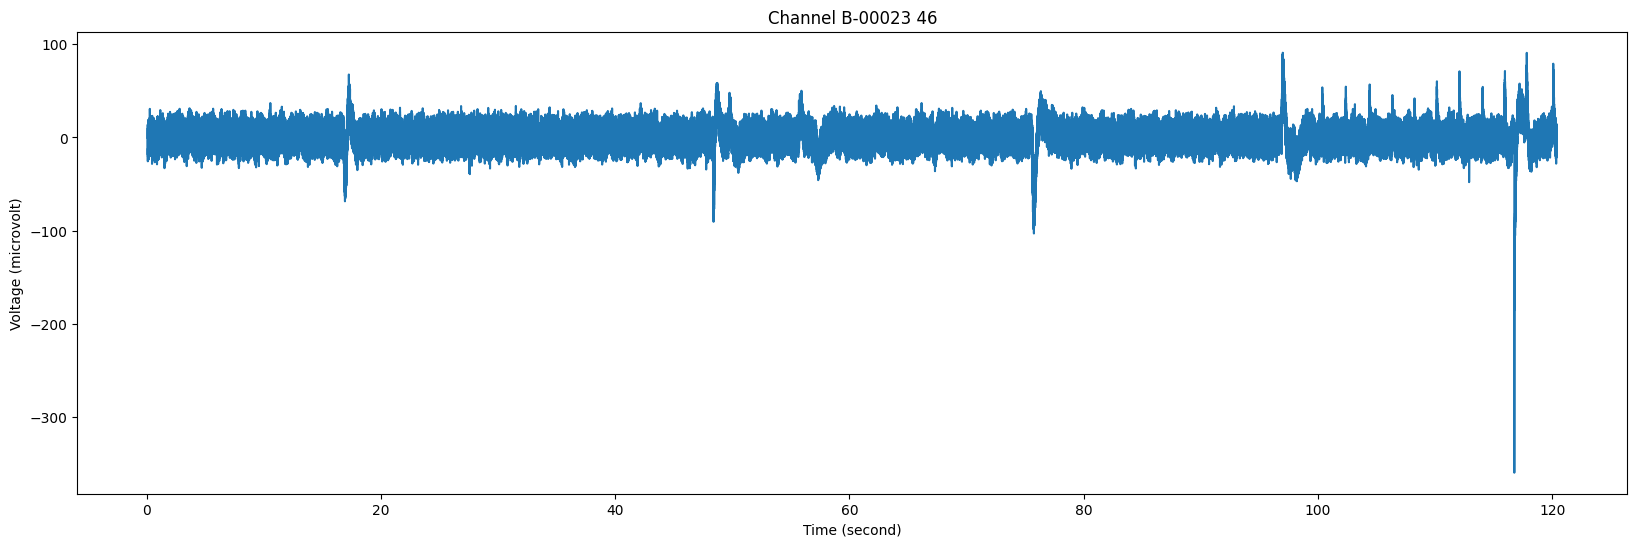

In [9]:
# Check the analog stream of the electrode in channel 0
plot_analog_stream_channel(electrode_stream, channel_idx = 2, from_in_s=0, to_in_s=10000)

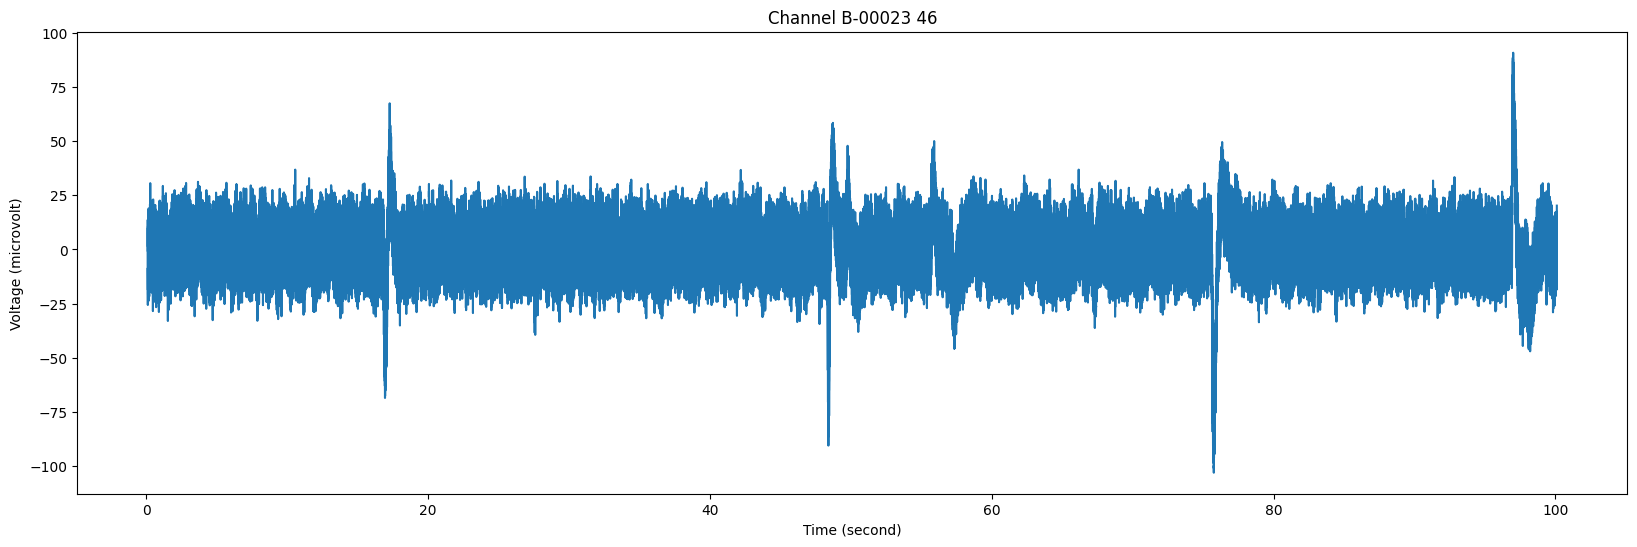

In [10]:
# Check the analog stream of the electrode in channel 0
plot_analog_stream_channel(electrode_stream, channel_idx = 2, from_in_s=0, to_in_s=100)

In [11]:
# Check the bandwidth of the recording to see if
# there have been any filters applied o
channel_id = 2
info = electrode_stream.channel_infos[channel_id].info
print("Bandwidth: %s - %s Hz" % (info['HighPassFilterCutOffFrequency'], info['LowPassFilterCutOffFrequency']))

signal = electrode_stream.get_channel_in_range(channel_id, 0, electrode_stream.channel_data.shape[1])[0]

Bandwidth: -1 - -1 Hz


In [13]:
# Export signal as bin file:
signal.astype('int16').tofile("testing.bin")


In [16]:
# Determine suitable threshold for spike detection
noise_std = np.std(signal)
noise_mad = np.median(np.absolute(signal)) / 0.6745
print('Noise Estimate by Standard Deviation: {0:g} V'.format(noise_std))
print('Noise Estimate by MAD Estimator     : {0:g} V'.format(noise_mad))

Noise Estimate by Standard Deviation: 1.11438e-05 V
Noise Estimate by MAD Estimator     : 8.24163e-06 V


In [69]:
spike_threshold = -3.75 * noise_mad # roughly -30 µV

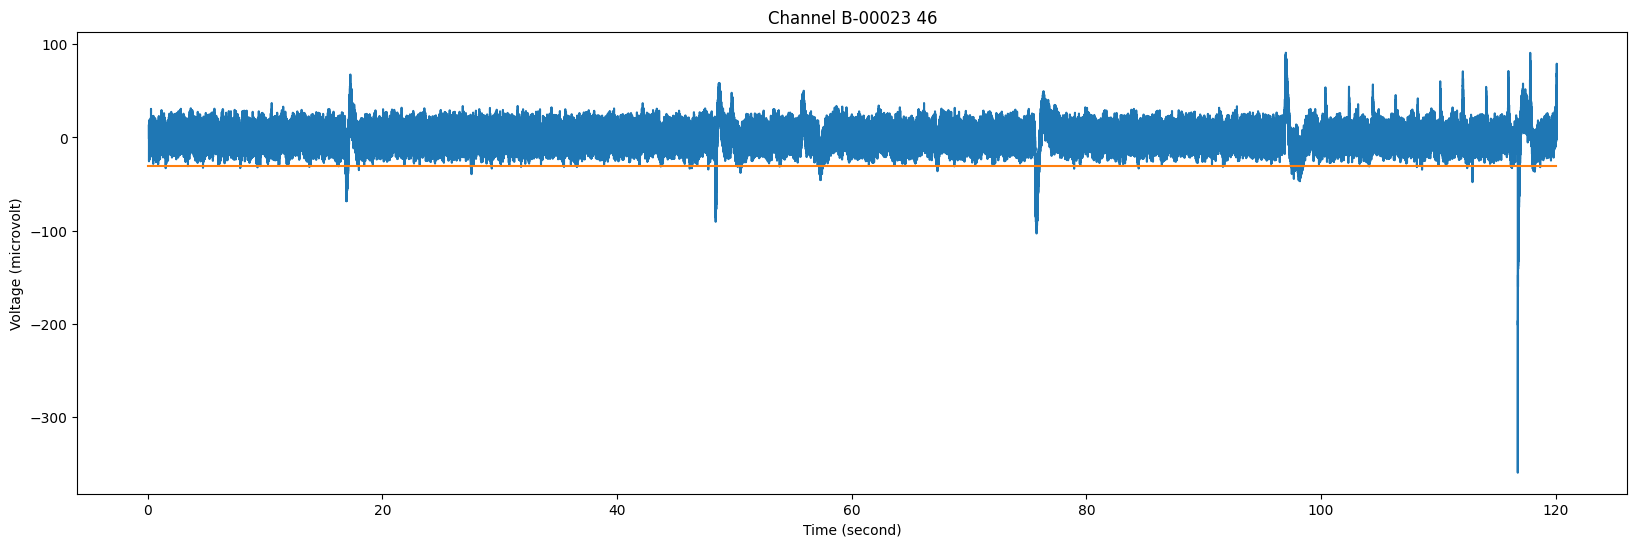

In [70]:
# Plot the data with the spike threshold
plot_analog_stream_channel(electrode_stream, 2, from_in_s=0, to_in_s=120, show=False)

plt.plot([0, 120], [spike_threshold*1e6, spike_threshold*1e6]) # converts the threshold to µV for plotting
plt.show()

In [115]:
fs = int(electrode_stream.channel_infos[channel_id].sampling_frequency.magnitude)
crossings_neg = detect_threshold_crossings(signal, fs, spike_threshold, 0.003) # dead time of 3 ms
crossings_pos = detect_threshold_crossings(signal, fs, -spike_threshold, 0.003) # dead time of 3 ms
crossings = np.concatenate((crossings_neg, crossings_pos)) 

In [116]:
crossings

array([  28598,   92213,  155662,  155872,  185079,  273559,  323552,
        335161,  335862,  335970,  336413,  336744,  336898,  337409,
        337508,  337797,  337918,  338076,  338221,  338376,  338445,
        339453,  339544,  339741,  357969,  548792,  549069,  549164,
        549449,  549581,  549991,  550146,  584471,  634358,  707582,
        729522,  872590,  921931,  925159,  925576,  953546,  965217,
        967279,  967353,  967457,  967726,  967853,  967921, 1003749,
       1007560, 1007741, 1007963, 1008350, 1008497, 1008727, 1008865,
       1009018, 1009143, 1010155, 1075213, 1142407, 1142494, 1143104,
       1143196, 1143434, 1143528, 1143990, 1144074, 1144306, 1144557,
       1144728, 1144792, 1145192, 1145589, 1146053, 1146187, 1146297,
       1146399, 1146548, 1146692, 1146893, 1147097, 1147216, 1147383,
       1147781, 1148229, 1148824, 1344230, 1345089, 1373034, 1510705,
       1510813, 1516047, 1517610, 1577188, 1687212, 1830886, 1947336,
       1948172, 1948

In [117]:
spks = align_to_minimum(signal, fs, crossings, 0.002) # search range 2 ms

In [118]:
timestamps = spks / fs
range_in_s = (0, 120)
spikes_in_range = timestamps[(timestamps >= range_in_s[0]) & (timestamps <= range_in_s[1])]


In [119]:
spikes_in_range

array([  1.42995,   4.61075,   7.78315,   7.79365,   9.254  ,  13.678  ,
        16.17765,  16.75835,  16.7932 ,  16.8004 ,  16.82165,  16.83835,
        16.84595,  16.87145,  16.8762 ,  16.8915 ,  16.89775,  16.90505,
        16.91145,  16.9195 ,  16.92415,  16.97395,  16.9783 ,  16.98715,
        17.89855,  27.43965,  27.45355,  27.45945,  27.47255,  27.4796 ,
        27.49995,  27.50735,  29.22365,  31.71795,  35.37915,  36.47615,
        43.62955,  46.09665,  46.25805,  46.2789 ,  47.6774 ,  48.26265,
        48.3654 ,  48.3694 ,  48.3737 ,  48.38635,  48.3927 ,  48.39615,
        50.1875 ,  50.37955,  50.3871 ,  50.39825,  50.41835,  50.42495,
        50.43805,  50.44335,  50.451  ,  50.4574 ,  50.50785,  53.76075,
        57.12045,  57.1248 ,  57.15595,  57.1599 ,  57.17175,  57.1771 ,
        57.1997 ,  57.2044 ,  57.21545,  57.2297 ,  57.23645,  57.2412 ,
        57.2614 ,  57.2811 ,  57.30275,  57.30945,  57.31495,  57.32105,
        57.32745,  57.3349 ,  57.3447 ,  57.355  , 

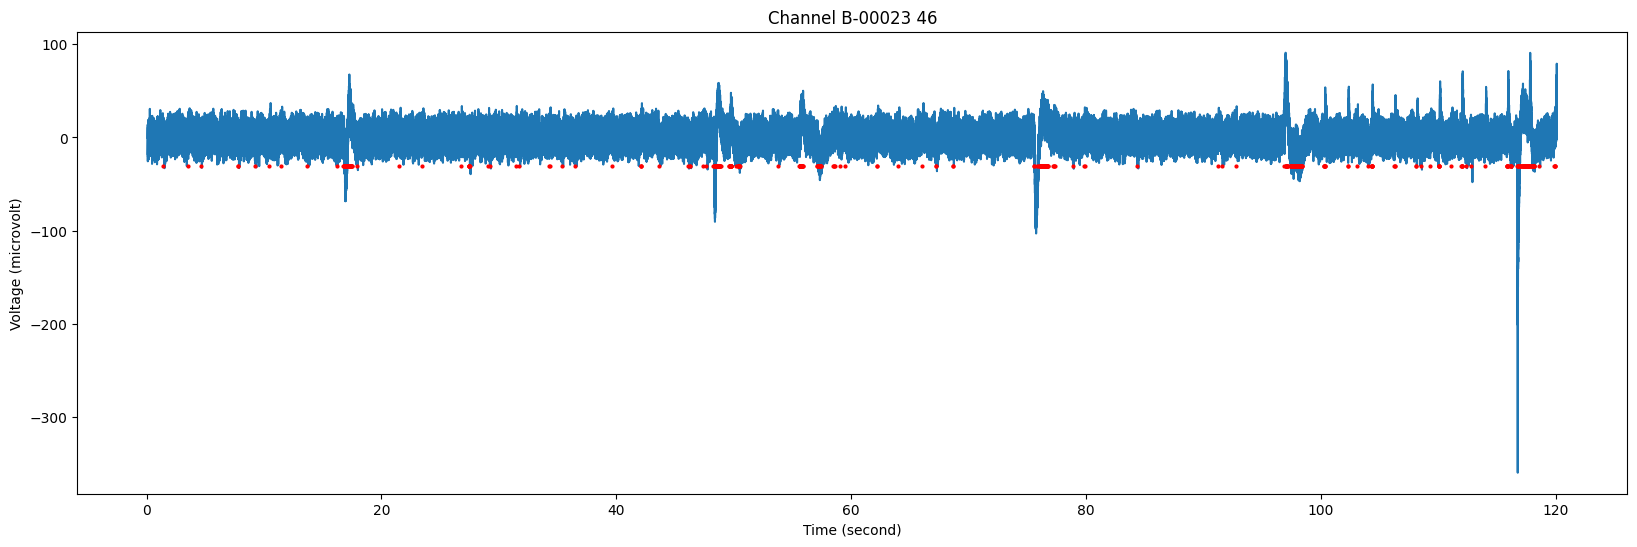

In [120]:

plot_analog_stream_channel(electrode_stream, channel_idx = 2, from_in_s=0, to_in_s=120, show=False)
plt.plot(spikes_in_range, [spike_threshold*1e6]*spikes_in_range.shape[0], 'ro', ms=2)
plt.show()

Text(0.5, 1.0, 'Output raster')

Text(0.5, 0, 'Time (s)')

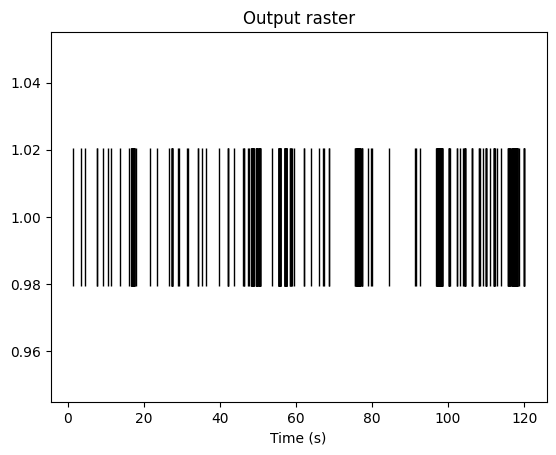

In [146]:
# plot spike train
plt.plot(spikes_in_range, np.ones_like(spikes_in_range), '|', markersize=100, color='black')
plt.title('Output raster')
plt.xlabel('Time (s)')


In [121]:
pre = 0.002 # 1 ms
post= 0.003 # 2 ms
cutouts = extract_waveforms(signal, fs, spks, pre, post)
print("Cutout array shape: " + str(cutouts.shape)) # number of spikes x number of samples

Cutout array shape: (482, 100)


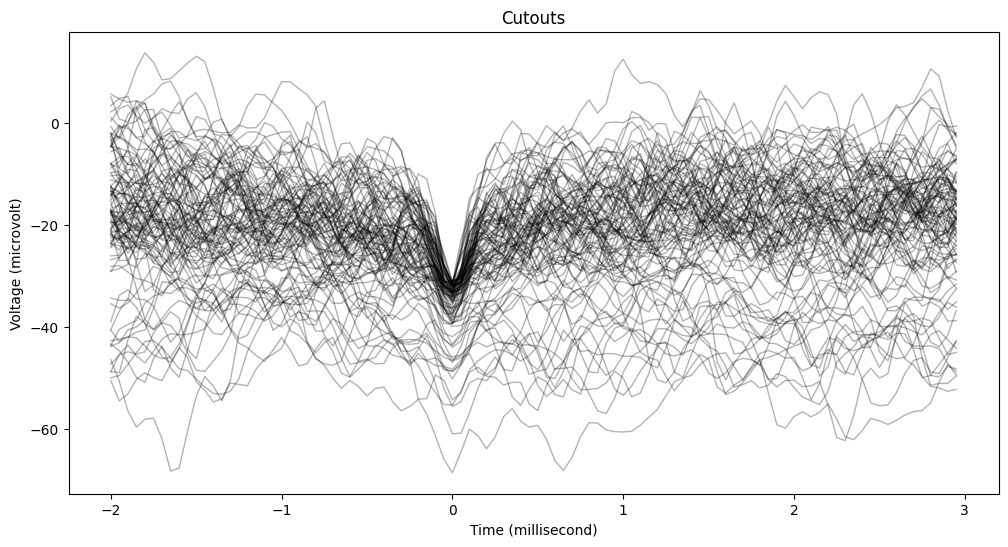

In [122]:
plot_waveforms(cutouts, fs, pre, post, n=100)

Crosscorrelations 

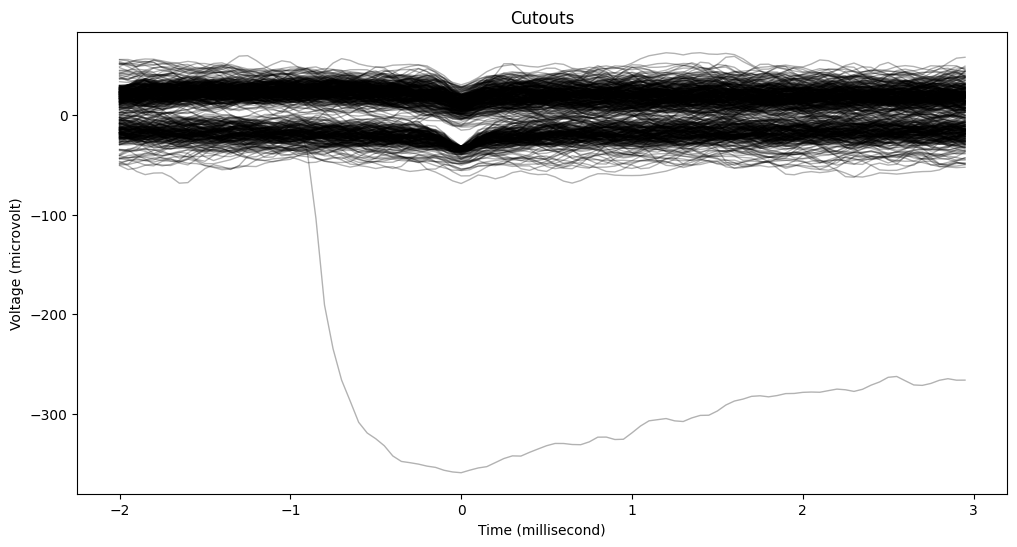

In [128]:
plot_waveforms(cutouts, fs, pre, post, n = 480)


In [126]:
# len(cutouts)

482

Analysis with PCA

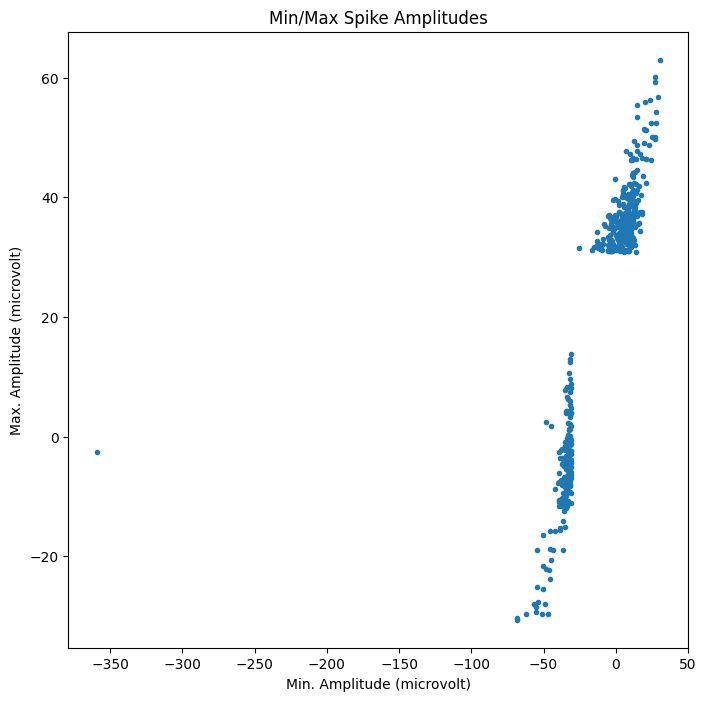

In [129]:
min_amplitude = np.amin(cutouts, axis=1)
max_amplitude = np.amax(cutouts, axis=1)

_ = plt.figure(figsize=(8,8))
_ = plt.plot(min_amplitude*1e6, max_amplitude*1e6,'.')
_ = plt.xlabel('Min. Amplitude (%s)' % ureg.uV)
_ = plt.ylabel('Max. Amplitude (%s)' % ureg.uV)
_ = plt.title('Min/Max Spike Amplitudes')

plt.show()

In [130]:
scaler = StandardScaler()
scaled_cutouts = scaler.fit_transform(cutouts)

pca = PCA()
pca.fit(scaled_cutouts)
print(pca.explained_variance_ratio_)

,n_components,None
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


[8.94315268e-01 5.93041725e-02 7.87606224e-03 4.72776695e-03
 4.54096551e-03 2.76657912e-03 2.62344127e-03 1.99132145e-03
 1.83540277e-03 1.71442516e-03 1.56248966e-03 1.26710102e-03
 1.09619603e-03 1.07317424e-03 1.01479547e-03 9.38397312e-04
 8.65156645e-04 8.14825265e-04 7.75284412e-04 7.24158057e-04
 6.15952146e-04 5.77587473e-04 5.50063161e-04 5.15452908e-04
 4.87081432e-04 4.43776871e-04 4.05111601e-04 3.79660327e-04
 3.71065180e-04 3.39970665e-04 3.32486859e-04 2.93738450e-04
 2.51877193e-04 2.39225492e-04 2.20467363e-04 1.93852402e-04
 1.87075508e-04 1.66859186e-04 1.46575119e-04 1.33103723e-04
 1.26639435e-04 1.20500345e-04 1.00546996e-04 9.74624712e-05
 9.38811293e-05 7.66570616e-05 7.23313005e-05 6.47333569e-05
 5.86012944e-05 4.91101976e-05 4.85144637e-05 4.40768152e-05
 3.79507287e-05 3.26393055e-05 3.06435419e-05 2.84357446e-05
 2.69861797e-05 2.28193971e-05 2.09630990e-05 1.88398281e-05
 1.66064003e-05 1.35433878e-05 1.26379941e-05 1.07220861e-05
 9.27615383e-06 8.789840

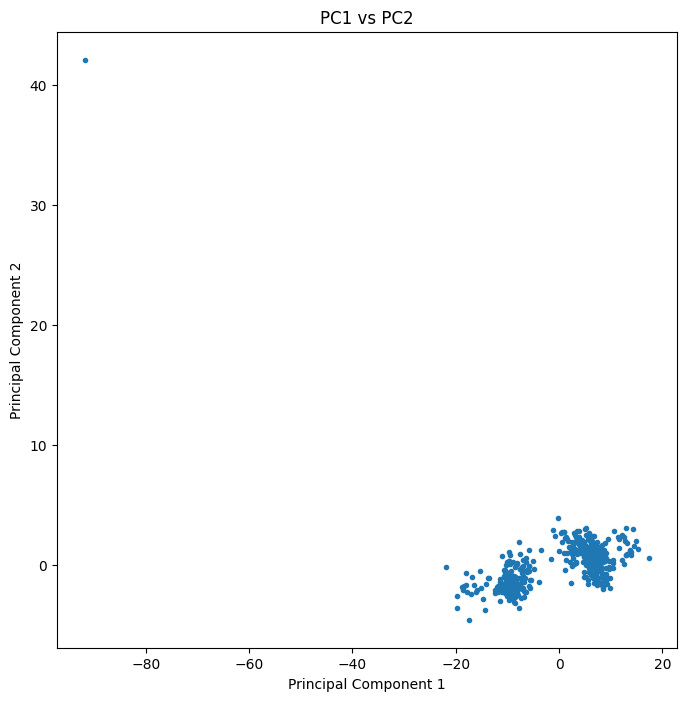

In [131]:
pca.n_components = 2
transformed = pca.fit_transform(scaled_cutouts)

_ = plt.figure(figsize=(8,8))
_ = plt.plot(transformed[:,0], transformed[:,1],'.')
_ = plt.xlabel('Principal Component 1')
_ = plt.ylabel('Principal Component 2')
_ = plt.title('PC1 vs PC2')

plt.show()

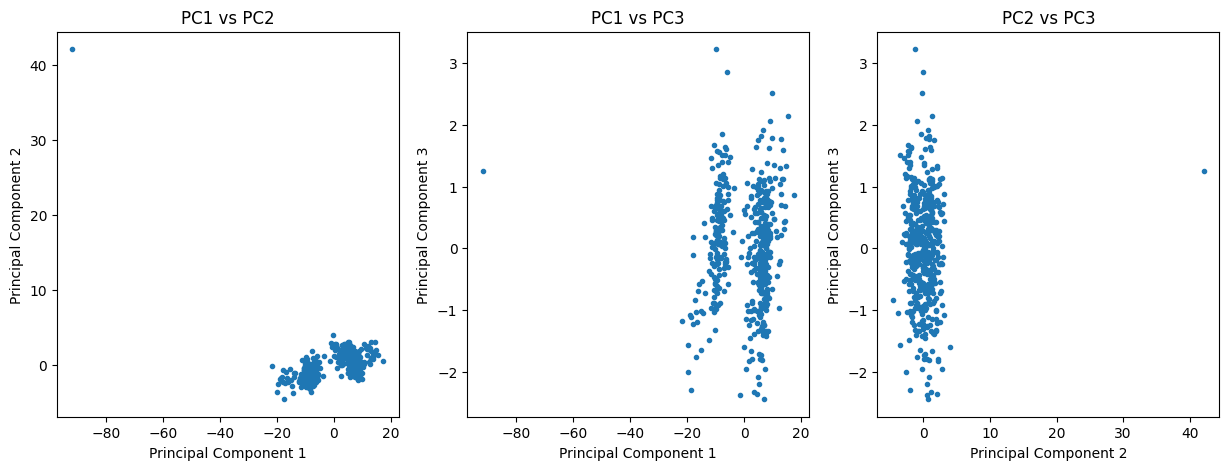

In [132]:
pca.n_components = 3
transformed_3d = pca.fit_transform(scaled_cutouts)

_ = plt.figure(figsize=(15,5))
_ = plt.subplot(1, 3, 1)
_ = plt.plot(transformed_3d[:,0], transformed_3d[:,1],'.')
_ = plt.xlabel('Principal Component 1')
_ = plt.ylabel('Principal Component 2')
_ = plt.title('PC1 vs PC2')
_ = plt.subplot(1, 3, 2)
_ = plt.plot(transformed_3d[:,0], transformed_3d[:,2],'.')
_ = plt.xlabel('Principal Component 1')
_ = plt.ylabel('Principal Component 3')
_ = plt.title('PC1 vs PC3')
_ = plt.subplot(1, 3, 3)
_ = plt.plot(transformed_3d[:,1], transformed_3d[:,2],'.')
_ = plt.xlabel('Principal Component 2')
_ = plt.ylabel('Principal Component 3')
_ = plt.title('PC2 vs PC3')
plt.show()

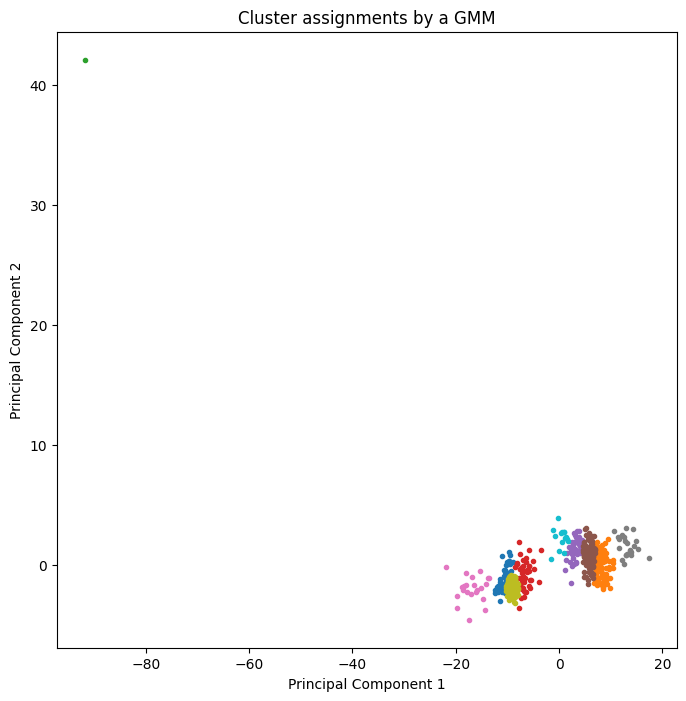

In [134]:
# Clustering
n_components = 10
gmm = GaussianMixture(n_components=n_components, n_init=10)
labels = gmm.fit_predict(transformed)

_ = plt.figure(figsize=(8,8))
for i in range(n_components):
    idx = labels == i
    _ = plt.plot(transformed[idx,0], transformed[idx,1],'.')
    _ = plt.title('Cluster assignments by a GMM')
    _ = plt.xlabel('Principal Component 1')
    _ = plt.ylabel('Principal Component 2')
    _ = plt.axis('tight')
plt.show()

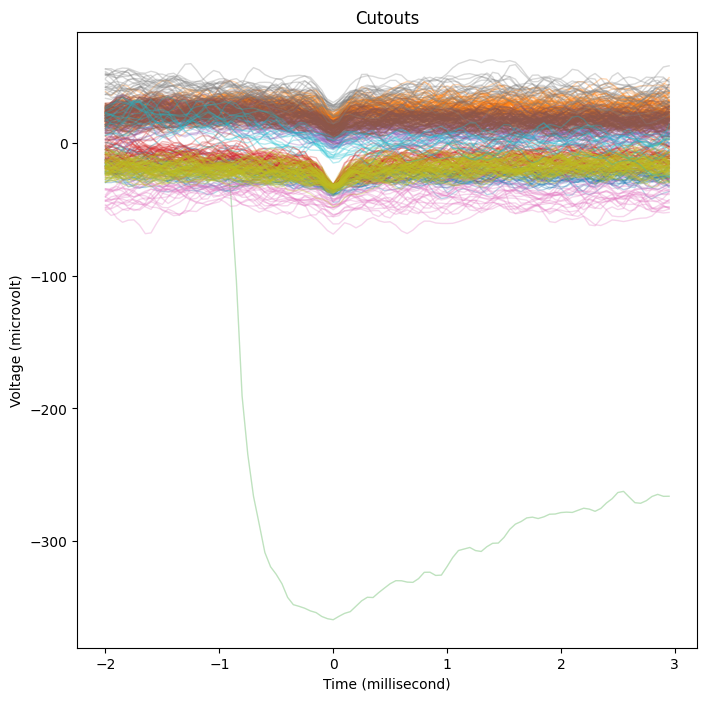

In [135]:
_ = plt.figure(figsize=(8,8))
for i in range(n_components):
    idx = labels == i
    color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i]
    plot_waveforms(cutouts[idx,:], fs, pre, post, n=100, color=color, show=False)
plt.show()

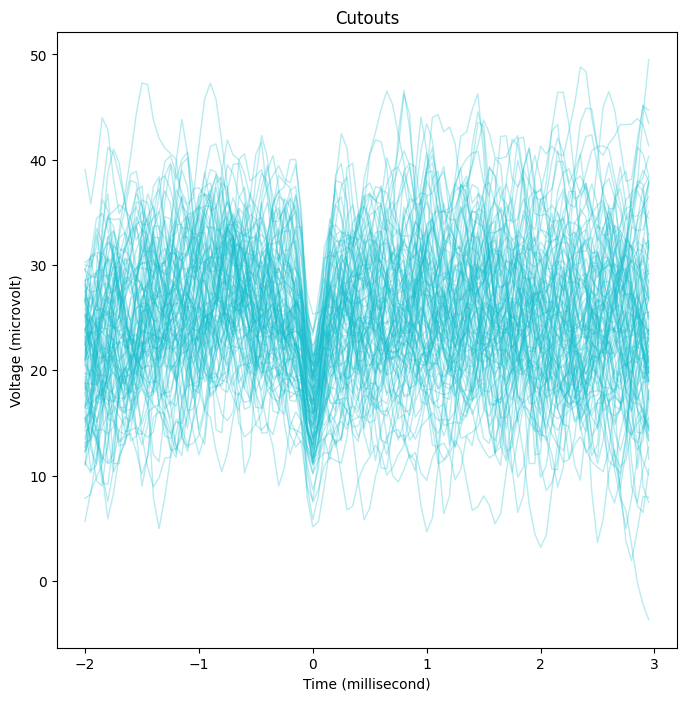

In [143]:
_ = plt.figure(figsize=(8,8))

idx = labels == 1
color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i]
plot_waveforms(cutouts[idx,:], fs, pre, post, n = 200, color=color, show=False)
plt.show()